# Synthetic Clear Sky

In this notebook, we generate a synthetic power signal for a system located in souther California. We make use of the `pvlib-python` PV modeling package. The goal is to compare the solar eigenvectors generated by this method to the eigenvectors generated from real data.

In [1]:
from sys import path
path.append('..')
from statistical_clear_sky.algorithm.iterative_fitting import IterativeFitting
from statistical_clear_sky.solver_type import SolverType
from pvlib.pvsystem import PVSystem, retrieve_sam
from pvlib.location import Location
from pvlib.modelchain import ModelChain
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='darkgrid', palette='colorblind', context='talk')

Load the Sandia module and CEC inverter databases.

In [2]:
# load some module and inverter specifications
sandia_modules = retrieve_sam('SandiaMod')
cec_inverters = retrieve_sam('cecinverter')

sandia_module = sandia_modules['SunPower_SP305_GEN_C_Module__2008__E__']
cec_inverter = cec_inverters['SMA_America__SB3000US_240V__CEC_2007_']

Set up the system and location  model chain.

In [3]:
location = Location(latitude=33.68, longitude=-117.82, altitude=60, tz='America/Los_Angeles')
system = PVSystem(surface_tilt=30, surface_azimuth=100,
                  module_parameters=sandia_module,
                  inverter_parameters=cec_inverter)
mc = ModelChain(system, location)

Create the time index for the simulated data.

In [4]:
times = pd.DatetimeIndex(start='2016-01-01', end='2017-01-01', freq='5min', tz=location.tz)

/Users/tadatoshi/.pyenv/versions/anaconda3-2018.12/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  """Entry point for launching an IPython kernel.


In [5]:
try:
    mc.run_model(times=times)
except KeyError as e:
    print(e)

Below we inspect a single day in the simulated data set.

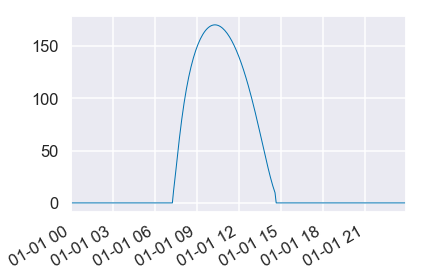

In [6]:
mc.ac.loc['2016-01-01':'2016-01-01'].plot(linewidth=1)

In [7]:
power_signals_d = mc.ac.values[:-1].reshape(288, -1, order='F')
p = mc.ac.values

In [8]:
cloudy_days = np.sort(np.random.choice(np.arange(power_signals_d.shape[1]), size=int(0.3 * power_signals_d.shape[1]), replace=False))
c = np.ones_like(power_signals_d)
for cd in cloudy_days:
    c[:, cd] = np.random.uniform(0, 1.1, c.shape[0])

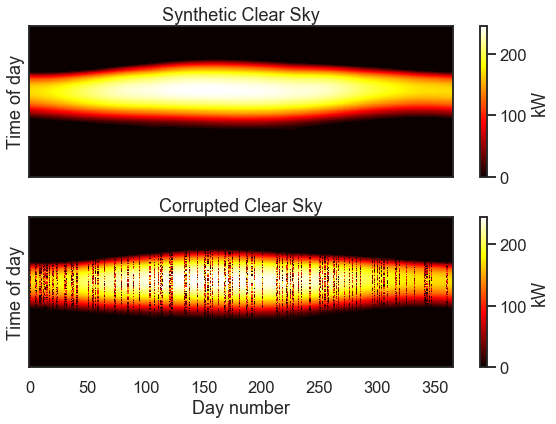

In [9]:
with sns.axes_style("white"):
    fig, ax = plt.subplots(nrows=2, figsize=(8,6), sharex=True)
    foo = ax[0].imshow(power_signals_d, cmap='hot', interpolation='none', aspect='auto')
    ax[0].set_title('Synthetic Clear Sky')
    bar = ax[1].imshow(np.multiply(power_signals_d, c), cmap='hot', vmin=0, vmax=np.max(power_signals_d), interpolation='none', aspect='auto')
    ax[1].set_title('Corrupted Clear Sky')
    plt.colorbar(foo, ax=ax[0], label='kW')#, ticks=range(0, 30, 5))
    plt.colorbar(bar, ax=ax[1], label='kW')#, ticks=range(0, 30, 5))
    ax[1].set_xlabel('Day number')
    ax[0].set_yticks([])
    ax[0].set_ylabel('Time of day')
    ax[1].set_yticks([])
    ax[1].set_ylabel('Time of day')
    plt.tight_layout()

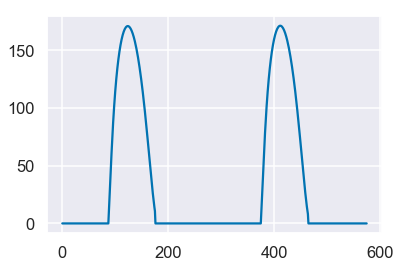

In [10]:
plt.plot(np.multiply(power_signals_d, c)[:, 2:4].ravel(order='F'))

In [13]:
iterative_fitting = IterativeFitting(power_signals_d * c, rank_k=5, solver_type=SolverType.mosek)

In [14]:
iterative_fitting.execute(mu_l=5e2, mu_r=1e3, tau=0.9, max_iteration=20)

obtaining initial value of component r0
obtaining weights
starting at 17531366.558 [47773.000819621564, 1887.7879313158182, 17481705.768815808, 0]
Miminizing left L matrix
Miminizing right R matrix
iteration 1: 21366.693 [18299.641    26.774  3040.278     0.   ]
Miminizing left L matrix
Miminizing right R matrix
iteration 2: 16375.405 [12972.96     50.348  3352.097     0.   ]
Miminizing left L matrix
Miminizing right R matrix
iteration 3: 12325.536 [9174.473   54.128 3096.934    0.   ]
Miminizing left L matrix
Miminizing right R matrix
iteration 4: 10242.475 [7007.595   64.278 3170.602    0.   ]
Miminizing left L matrix
Miminizing right R matrix
iteration 5: 9473.793 [6147.046   76.392 3250.355    0.   ]
Miminizing left L matrix
Miminizing right R matrix
iteration 6: 9149.476 [5827.487   79.453 3242.536    0.   ]
Miminizing left L matrix
Miminizing right R matrix
iteration 7: 8946.082 [5642.407   81.467 3222.208    0.   ]
Miminizing left L matrix
Miminizing right R matrix
iteration 8: 

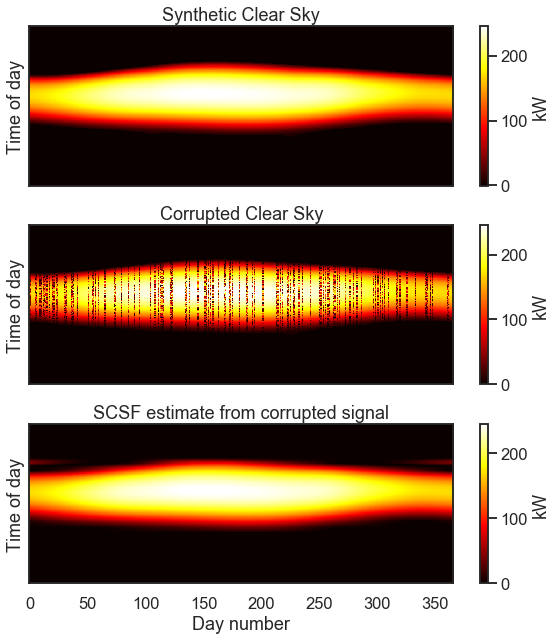

In [15]:
with sns.axes_style("white"):
    fig, ax = plt.subplots(nrows=3, figsize=(8,9), sharex=True)
    foo = ax[0].imshow(power_signals_d, cmap='hot', interpolation='none', aspect='auto')
    ax[0].set_title('Synthetic Clear Sky')
    bar = ax[2].imshow(iterative_fitting.clear_sky_signals(), cmap='hot', vmin=0, vmax=np.max(power_signals_d), interpolation='none', aspect='auto')
    ax[2].set_title('SCSF estimate from corrupted signal')
    fubar = ax[1].imshow(power_signals_d*c, cmap='hot', interpolation='none', aspect='auto', vmin=0, vmax=np.max(power_signals_d))
    ax[1].set_title('Corrupted Clear Sky')
    plt.colorbar(foo, ax=ax[0], label='kW')#, ticks=range(0, 30, 5))
    plt.colorbar(bar, ax=ax[2], label='kW')#, ticks=range(0, 30, 5))
    plt.colorbar(fubar, ax=ax[1], label='kW')
    ax[2].set_xlabel('Day number')
    ax[0].set_yticks([])
    ax[0].set_ylabel('Time of day')
    ax[1].set_yticks([])
    ax[1].set_ylabel('Time of day')
    ax[2].set_yticks([])
    ax[2].set_ylabel('Time of day')
    plt.tight_layout()

In [16]:
np.linalg.norm(power_signals_d - iterative_fitting.clear_sky_signals(), 'fro')

1106.11267848381

In [17]:
np.linalg.norm(power_signals_d, 'fro')

32910.42510071854

In [20]:
np.linalg.norm(power_signals_d - iterative_fitting.clear_sky_signals(), 'fro') / np.linalg.norm(power_signals_d, 'fro')

0.03360979613902526

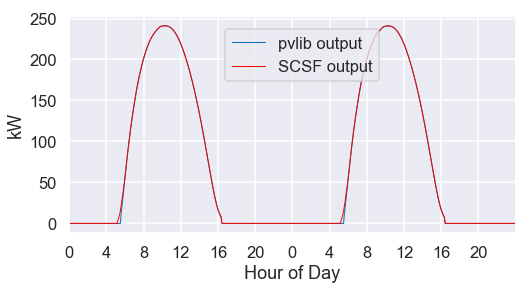

In [21]:
d1 = 205
d2 = d1 + 2
actual = p[d1*288:d2*288]
clearsky = ((iterative_fitting.clear_sky_signals()))[:, d1:d2].ravel(order='F')
fig, ax = plt.subplots(nrows=1, figsize=(8,4))
ax.plot(actual, linewidth=1, label='pvlib output')
ax.plot(clearsky, linewidth=1, color='red', label='SCSF output')
plt.legend(loc=(.35,.7))
ax.set_xlim(0, 288*(d2-d1))
ax.set_ylabel('kW')
ax.set_xticks(np.arange(0, 288*2, 2*24))
ax.set_xticklabels(np.tile(np.arange(0,24,4),2))
ax.set_xlabel('Hour of Day')
plt.show()

(0, 288)

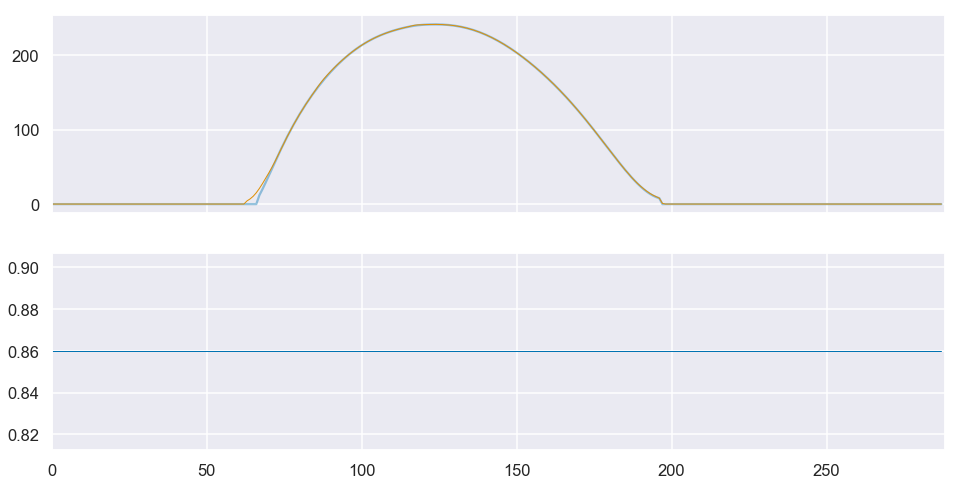

In [23]:
d1 = 205
d2 = d1+1
actual = p[d1*288:d2*288]
clearsky = ((iterative_fitting.clear_sky_signals()))[:, d1:d2].ravel(order='F')
fig, ax = plt.subplots(nrows=2, figsize=(16,8), sharex=True)
ax[0].plot(actual, alpha=0.4)
ax[0].plot(clearsky, linewidth=1)
ax[1].plot(np.repeat(iterative_fitting.weights[d1:d2], 288), linewidth=1)
ax[1].set_xlim(0, 288*(d2-d1))